In [74]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os

In [2]:
model = YOLO("yolov8m.pt")

In [3]:
def detect_on_image(image_path):
    results = model(image_path)
    annotated_image = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(annotated_image)
    plt.axis('off')  
    plt.show()


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\glupi_kot.jpg: 640x512 1 person, 2 cats, 35.0ms
Speed: 8.0ms preprocess, 35.0ms inference, 190.2ms postprocess per image at shape (1, 3, 640, 512)


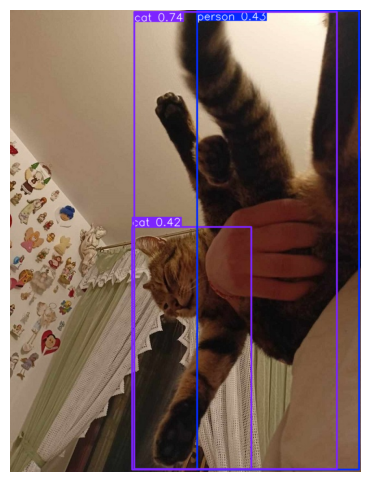

In [4]:
detect_on_image("glupi_kot.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\Jan_Boiler_III.jpg: 640x480 1 person, 54.9ms
Speed: 3.0ms preprocess, 54.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


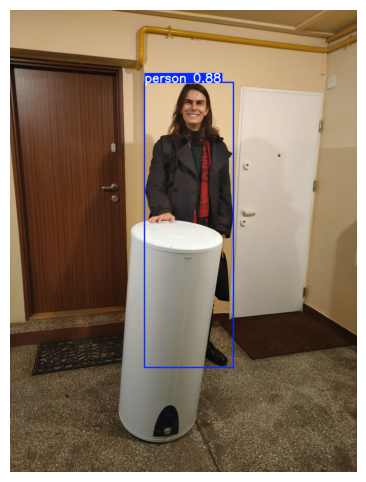

In [5]:
detect_on_image("Jan_Boiler_III.jpg")

In [7]:
train_annotations = pd.read_csv("train-annotations-human-imagelabels-boxable.csv")
train_annotations.head()

ImageID        Source  LabelName  Confidence
0  000002b66c9c498e  verification  /m/014j1m           0
1  000002b66c9c498e  verification  /m/014sv8           1
2  000002b66c9c498e  verification   /m/01599           0
3  000002b66c9c498e  verification   /m/015p6           0
4  000002b66c9c498e  verification  /m/015x4r           0

In [8]:
train_annotations = train_annotations[train_annotations["Confidence"] == 1]
train_annotations = train_annotations[train_annotations["LabelName"] == "/m/02wbm"]

In [9]:
train_annotations["ImageID_downloader"] = "train/" + train_annotations["ImageID"]
train_annotations.head(6000).to_csv("train_image_list.txt", columns=["ImageID_downloader"], index=False, header=False)

In [14]:
valid_annotations = pd.read_csv("validation-annotations-human-imagelabels-boxable.csv")
valid_annotations.head()

ImageID        Source  LabelName  Confidence
0  0001eeaf4aed83f9  verification   /m/0cmf2           1
1  0004886b7d043cfd  verification  /m/01g317           0
2  0004886b7d043cfd  verification  /m/04hgtk           0
3  0004886b7d043cfd  verification   /m/09j2d           0
4  0004886b7d043cfd  verification  /m/0463sg           0

In [15]:
valid_annotations = valid_annotations[valid_annotations["Confidence"] == 1]
valid_annotations = valid_annotations[valid_annotations["LabelName"] == "/m/02wbm"]

In [16]:
valid_annotations["ImageID_downloader"] = "validation/" + valid_annotations["ImageID"]
valid_annotations.head(2000).to_csv("valid_image_list.txt", columns=["ImageID_downloader"], index=False, header=False)

In [10]:
train_df = pd.read_csv("oidv6-train-annotations-bbox.csv")

In [56]:
train_df = train_df[train_df["ImageID"].isin(train_annotations["ImageID"].head(6000))]
train_df = train_df[["ImageID", "LabelName", "XMin", "XMax", "YMin", "YMax"]]

In [27]:
train_df.head()

ImageID  LabelName      XMin      XMax      YMin      YMax
0  000002b66c9c498e  /m/01g317  0.012500  0.195312  0.148438  0.587500
1  000002b66c9c498e  /m/01g317  0.025000  0.276563  0.714063  0.948438
2  000002b66c9c498e  /m/01g317  0.151562  0.310937  0.198437  0.590625
3  000002b66c9c498e  /m/01g317  0.256250  0.429688  0.651563  0.925000
4  000002b66c9c498e  /m/01g317  0.257812  0.346875  0.235938  0.385938

In [62]:
train_df.to_csv("train_labels.txt", index=False)

In [59]:
valid_df = pd.read_csv("validation-annotations-bbox.csv")

In [63]:
valid_df = valid_df[valid_df["ImageID"].isin(valid_annotations["ImageID"].head(2000))]
valid_df = valid_df[valid_df["LabelName"].isin(train_df["LabelName"])]
valid_df = valid_df[["ImageID", "LabelName", "XMin", "XMax", "YMin", "YMax"]]

In [64]:
valid_df.head()

ImageID LabelName      XMin      XMax      YMin      YMax
1  000595fe6fee6369  /m/02wbm  0.000000  1.000000  0.000000  1.000000
2  000595fe6fee6369  /m/02xwb  0.141384  0.179676  0.676275  0.731707
3  000595fe6fee6369  /m/02xwb  0.213549  0.253314  0.299335  0.354767
4  000595fe6fee6369  /m/02xwb  0.232695  0.288660  0.490022  0.545455
5  000595fe6fee6369  /m/02xwb  0.245950  0.291605  0.547672  0.605321

In [65]:
valid_df.to_csv("valid_labels.txt", index=False)

In [66]:
labels = pd.read_csv("oidv7-class-descriptions-boxable.csv")

In [67]:
labels = labels[labels["LabelName"].isin(train_df["LabelName"])]

In [68]:
labels.head()

LabelName DisplayName
6     /m/0jbk      Animal
7     /m/0_k2         Ant
9   /m/014j1m       Apple
11  /m/047v4b   Artichoke
15  /m/01fb_0       Bagel

In [69]:
class_names = {name: i for i, name in enumerate(labels["LabelName"])}

In [71]:
def make_yolo_labels(df, class_names, test_set):
    output_dir = f'data/{test_set}/labels'  # Output dataset folder
    
    os.makedirs(output_dir, exist_ok=True)
    
    for image_id, group in df.groupby('ImageID'):
        annotations = []
    
        for _, row in group.iterrows():
            label = class_names.get(row['LabelName'])
                
            x_center = (row['XMin'] + row['XMax']) / 2
            y_center = (row['YMin'] + row['YMax']) / 2
            width = row['XMax'] - row['XMin']
            height = row['YMax'] - row['YMin']
    
            annotations.append(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        if annotations:
            label_file = os.path.join(output_dir, f"{image_id}.txt")
            with open(label_file, 'w') as f:
                f.write('/n'.join(annotations))
    
    print(f"Conversion complete. YOLO label files saved in: {output_dir}")

In [72]:
make_yolo_labels(train_df, class_names, "train")

Conversion complete. YOLO label files saved in: data/train/labels


In [73]:
make_yolo_labels(valid_df, class_names, "valid")

Conversion complete. YOLO label files saved in: data/valid/labels


In [77]:
import yaml

def create_yolo_yaml(train_path, val_path, num_classes, class_names): 
    data = {
        'train': train_path,
        'val': val_path,
        'nc': num_classes,
        'names': {i: name for i, name in enumerate(class_names)}
    }

    with open('dataset.yaml', 'w') as file:
        yaml.dump(data, file, default_flow_style=False)

    print("YOLO dataset YAML file created: dataset.yaml")

In [82]:
create_yolo_yaml(
    train_path='/Users/k2002/Desktop/kody/moje zadania/.studia/sem7/mro/Image-recognition/lab4/data/train/images',
    val_path='/Users/k2002/Desktop/kody/moje zadania/.studia/sem7/mro/Image-recognition/lab4/data/valid/images',
    num_classes=len(labels),
    class_names=labels["DisplayName"].tolist()
)

YOLO dataset YAML file created: dataset.yaml


In [79]:
model = YOLO("yolov8n.pt")

In [83]:
model.train(data="dataset.yaml", epochs=10, device="cuda")

New https://pypi.org/project/ultralytics/8.3.33 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.32  Python-3.11.4 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

100%|██████████| 755k/755k [00:00<00:00, 5.11MB/s]

Overriding model.yaml nc=80 with nc=306

                   from  n    params  module                                       arguments                     


  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256,

100%|██████████| 5.35M/5.35M [00:00<00:00, 17.4MB/s]


AMP: checks passed 


train: Scanning C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\data\train\labels... 6000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:03<00:00, 1780.89it/s]

train: WARNING  C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\data\train\images\0071689b11f8a240.jpg: 1 duplicate labels removed


train: New cache created: C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\data\train\labels.cache


val: Scanning C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\data\valid\labels... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:01<00:00, 1062.99it/s]


val: New cache created: C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\data\valid\labels.cache
Plotting labels to C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=3.2e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\runs\detect\train3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.54G      1.247      5.728      1.449        125        640: 100%|██████████| 375/375 [01:17<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:30<00:00,  1.44s/it]


                   all       2000      10936    0.00601     0.0158    0.00467     0.0033

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.46G      1.208      5.338      1.428        129        640: 100%|██████████| 375/375 [01:06<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:27<00:00,  1.38s/it]


                   all       2000      10936    0.00553      0.078    0.00918    0.00665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.47G      1.236      4.914      1.449        138        640: 100%|██████████| 375/375 [01:05<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


                   all       2000      10936      0.561     0.0207     0.0142     0.0103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.72G      1.248      4.627      1.462         99        640: 100%|██████████| 375/375 [01:03<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:14<00:00,  1.19s/it]


                   all       2000      10936      0.545       0.03     0.0234     0.0177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.54G       1.25      4.466       1.47         98        640: 100%|██████████| 375/375 [01:03<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


                   all       2000      10936      0.483     0.0374     0.0288     0.0221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.76G      1.251      4.345      1.467        130        640: 100%|██████████| 375/375 [01:03<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:39<00:00,  1.58s/it]


                   all       2000      10936      0.503     0.0404     0.0329     0.0253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.72G      1.254      4.277      1.474         73        640: 100%|██████████| 375/375 [01:04<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


                   all       2000      10936      0.482      0.055     0.0349     0.0273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.48G      1.256      4.222      1.475         84        640: 100%|██████████| 375/375 [01:03<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


                   all       2000      10936      0.464     0.0576     0.0368     0.0288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.86G      1.246      4.177      1.474        108        640: 100%|██████████| 375/375 [01:03<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:32<00:00,  1.46s/it]


                   all       2000      10936      0.459     0.0626     0.0363     0.0281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.54G      1.241      4.133      1.465         65        640: 100%|██████████| 375/375 [01:03<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


                   all       2000      10936      0.452     0.0636     0.0374      0.029

10 epochs completed in 0.408 hours.
Optimizer stripped from C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\runs\detect\train3\weights\last.pt, 7.0MB
Optimizer stripped from C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\runs\detect\train3\weights\best.pt, 7.0MB

Validating C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\runs\detect\train3\weights\best.pt...
Ultralytics 8.3.32  Python-3.11.4 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080, 8192MiB)
Model summary (fused): 168 layers, 3,403,142 parameters, 0 gradients, 10.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]


                   all       2000      10936      0.453     0.0639     0.0374      0.029
                Animal          2          2          1          0          0          0
                 Apple         11         48     0.0435      0.312     0.0693     0.0648
             Artichoke         10         14          1          0          0          0
                 Bagel          2         11          1          0          0          0
           Baked goods         98        247      0.121      0.255     0.0792     0.0621
                Banana          4          6          0          0    0.00159    0.00105
                 Beard          1          1          0          0          0          0
                   Bee          2          6          0          0          0          0
                  Beer          7         13          0          0     0.0181     0.0129
           Bell pepper         15         36          1          0     0.0142     0.0128
                  Bir

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   2,   3,   4,   5,   7,  11,  12,  13,  14,  18,  22,  23,  24,  25,  26,  27,  28,  29,  31,  32,  33,  35,  36,  37,  38,  39,  41,  42,  43,  46,  47,  49,  50,  52,  53,  54,  55,  56,  60,  64,  65,  66,  68,  69,  70,  71,  72,  75,  78,  82,  85,  86,  87,  88,  89,  92,  94,  95,  98, 100, 101,
       102, 105, 106, 108, 109, 110, 111, 112, 113, 115, 116, 119, 120, 121, 122, 123, 124, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 160, 162, 164, 165, 166, 171, 172, 173, 174, 176, 177, 178, 179, 180, 182, 185, 186,
       187, 188, 189, 191, 192, 193, 194, 195, 197, 198, 202, 203, 204, 206, 208, 209, 210, 212, 213, 214, 215, 218, 219, 221, 223, 225, 226, 229, 231, 234, 235, 236, 238, 239, 242, 245, 247, 248, 249, 250, 252, 253, 255, 259, 262, 263, 264, 265, 266, 267, 268, 274, 277, 280, 281, 283, 2

In [87]:
results = pd.read_csv("../runs/detect/train3/results.csv")
results.head()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  227.899         1.24726         5.72772         1.44890   
1      2  407.196         1.20800         5.33761         1.42770   
2      3  520.109         1.23617         4.91426         1.44855   
3      4  659.778         1.24765         4.62662         1.46231   
4      5  769.041         1.25020         4.46647         1.46974   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.00601            0.01580           0.00467   
1               0.00553            0.07797           0.00918   
2               0.56121            0.02070           0.01421   
3               0.54506            0.03000           0.02341   
4               0.48253            0.03739           0.02876   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.00330       1.03369       5.05335       1.29657  0.000011   
1              0.00665       1.06961       4.47141       1.33877  0.000019   
2              0.01025       1.08360       4.26202       1.34696  0.000026   
3              0.01767       1.09540       4.10268       1.36035  0.000022   
4              0.02212       1.09777       4.03805       1.36238  0.000019   

     lr/pg1    lr/pg2  
0  0.000011  0.000011  
1  0.000019  0.000019  
2  0.000026  0.000026  
3  0.000022  0.000022  
4  0.000019  0.000019

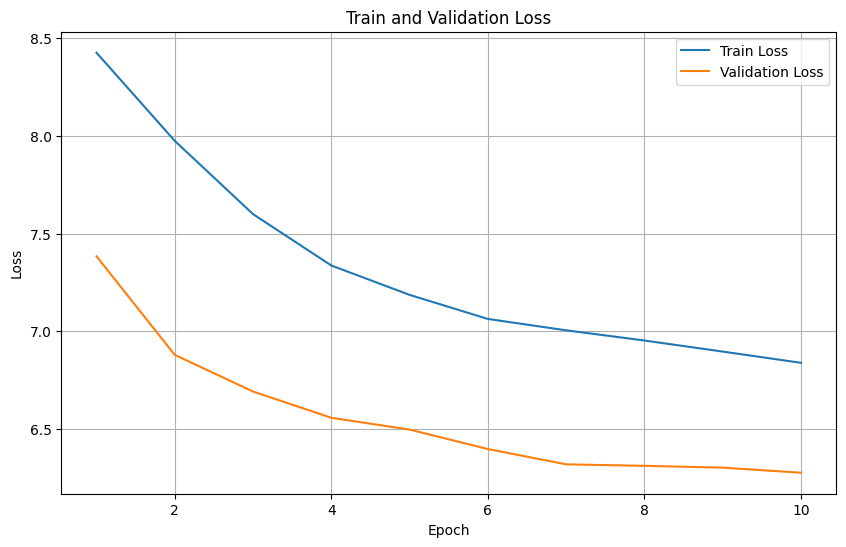

In [92]:
train_loss = results["train/box_loss"] + results["train/cls_loss"] + results["train/dfl_loss"]  
val_loss = results["val/box_loss"] + results["val/cls_loss"] + results["val/dfl_loss"] 

plt.figure(figsize=(10, 6))
plt.plot(results["epoch"], train_loss, label="Train Loss")
plt.plot(results["epoch"], val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid()
plt.show()


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\igor_obiad.jpg: 640x480 1 Food, 78.4ms
Speed: 6.0ms preprocess, 78.4ms inference, 28.2ms postprocess per image at shape (1, 3, 640, 480)


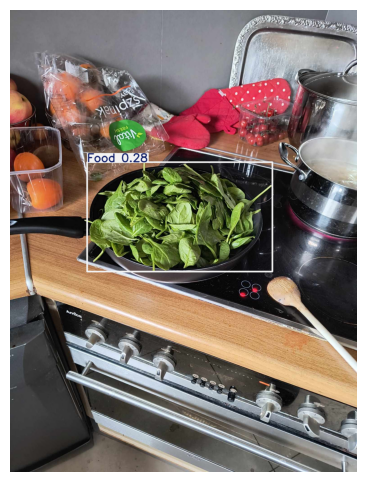

In [94]:
detect_on_image("igor_obiad.jpg")

In [203]:
food_numbers = [
    4, 5, 7, 26, 27, 29, 33, 37, 41, 47, 55, 56, 65, 69, 70, 71, 85,
    95, 102, 108, 109, 119, 120, 121, 122, 129, 143, 148, 166, 179, 189,
    191, 192, 193, 194, 202, 204, 211, 213, 214, 215, 223, 225, 242
]


In [204]:
def censore_food(image_path):
    results = model(image_path)
    image = cv2.imread(image_path)
    for result in results:
        for pred in result.boxes:
            if pred.cls in food_numbers:
                x, y, w, h = map(int, pred.xywh[0])
                h //= 2
                w //= 2
                image[y-h:y+h, x-w:x+w] = cv2.GaussianBlur(image[y-h:y+h, x-w:x+w], (201, 201), 0)
    return image

def detect_on_image(image_path):
    results = model(image_path)
    annotated_image = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)
    return annotated_image

def show_images_side_by_side(image_path):
    original_image = detect_on_image(image_path)
    censored_image = censore_food(image_path)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0})
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(censored_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Censored Image")
    axes[1].axis('off')

    plt.show()


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\igor_obiad.jpg: 640x480 1 Food, 39.0ms
Speed: 21.0ms preprocess, 39.0ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\igor_obiad.jpg: 640x480 1 Food, 60.1ms
Speed: 9.0ms preprocess, 60.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 480)


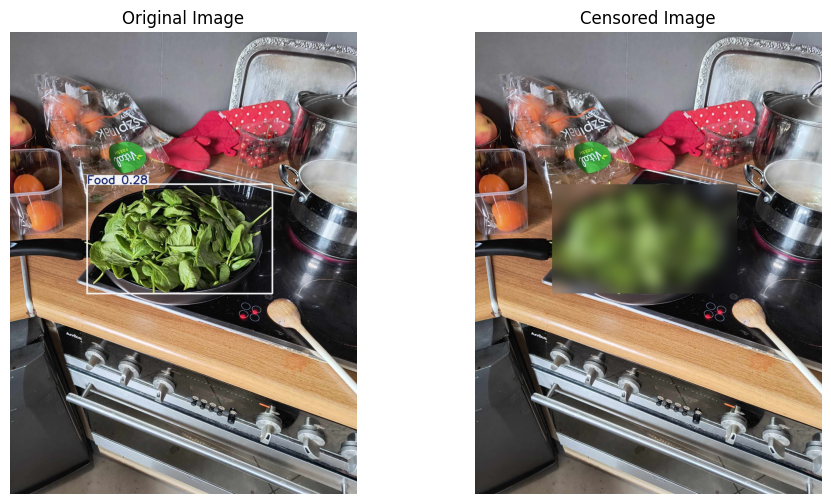

In [183]:
show_images_side_by_side("igor_obiad.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\sziszu_z_adamem.jpg: 640x480 2 Foods, 38.9ms
Speed: 5.0ms preprocess, 38.9ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\sziszu_z_adamem.jpg: 640x480 2 Foods, 57.0ms
Speed: 7.0ms preprocess, 57.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


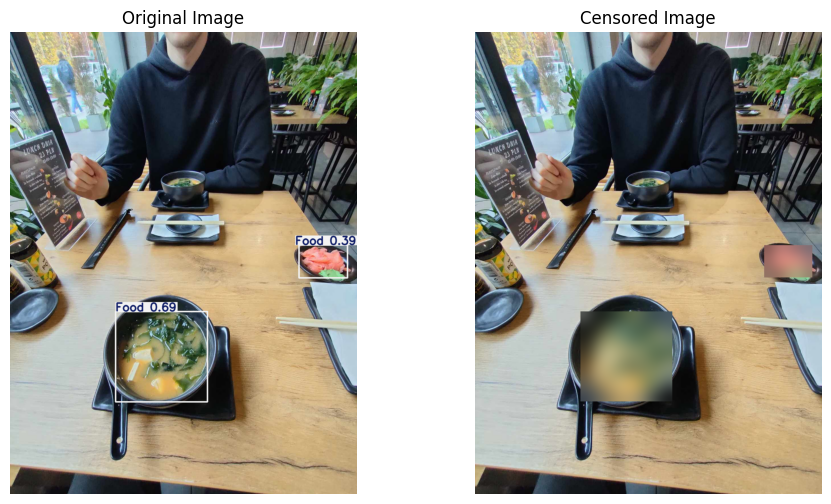

In [184]:
show_images_side_by_side("sziszu_z_adamem.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\cepibula.jpg: 640x512 (no detections), 36.8ms
Speed: 20.0ms preprocess, 36.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\cepibula.jpg: 640x512 (no detections), 44.2ms
Speed: 4.0ms preprocess, 44.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 512)


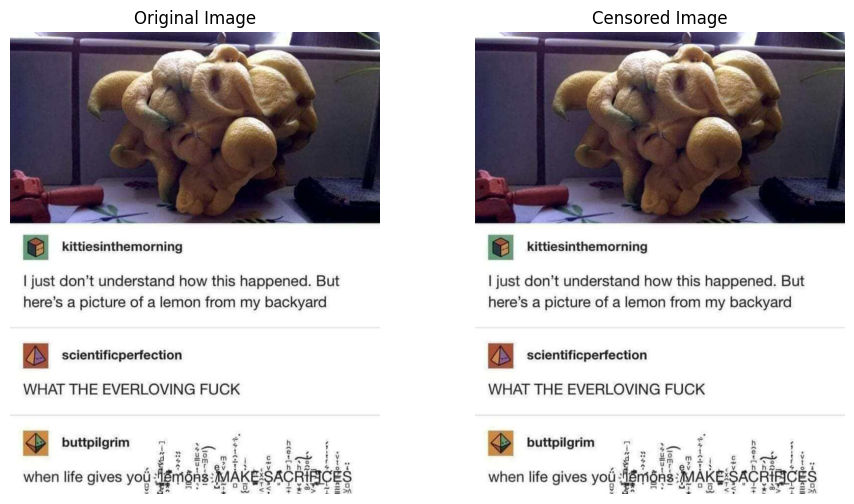

In [185]:
show_images_side_by_side("cepibula.jpg")

In [186]:
censore_food("zapiekanka.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\zapiekanka.jpg: 640x480 (no detections), 31.2ms
Speed: 9.9ms preprocess, 31.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


array([[[151, 146, 147],
        [151, 146, 147],
        [153, 148, 149],
        ...,
        [ 62,  59, 144],
        [ 62,  59, 145],
        [ 62,  59, 145]],

       [[151, 146, 147],
        [151, 146, 147],
        [153, 148, 149],
        ...,
        [ 62,  59, 144],
        [ 62,  59, 145],
        [ 62,  59, 145]],

       [[151, 146, 147],
        [151, 146, 147],
        [153, 148, 149],
        ...,
        [ 64,  59, 144],
        [ 64,  59, 144],
        [ 64,  59, 144]],

       ...,

       [[207, 220, 222],
        [192, 205, 207],
        [176, 189, 191],
        ...,
        [ 93, 131, 173],
        [ 91, 129, 171],
        [ 89, 127, 169]],

       [[216, 229, 231],
        [205, 218, 220],
        [190, 203, 205],
        ...,
        [ 88, 126, 168],
        [ 90, 128, 170],
        [ 89, 127, 169]],

       [[209, 222, 224],
        [208, 221, 223],
        [202, 215, 217],
        ...,
        [ 85, 123, 165],
        [ 88, 126, 168],
        [ 88, 126, 168]]


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\smakowity.jpg: 576x640 (no detections), 68.8ms
Speed: 6.2ms preprocess, 68.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\smakowity.jpg: 576x640 (no detections), 66.0ms
Speed: 6.1ms preprocess, 66.0ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 640)


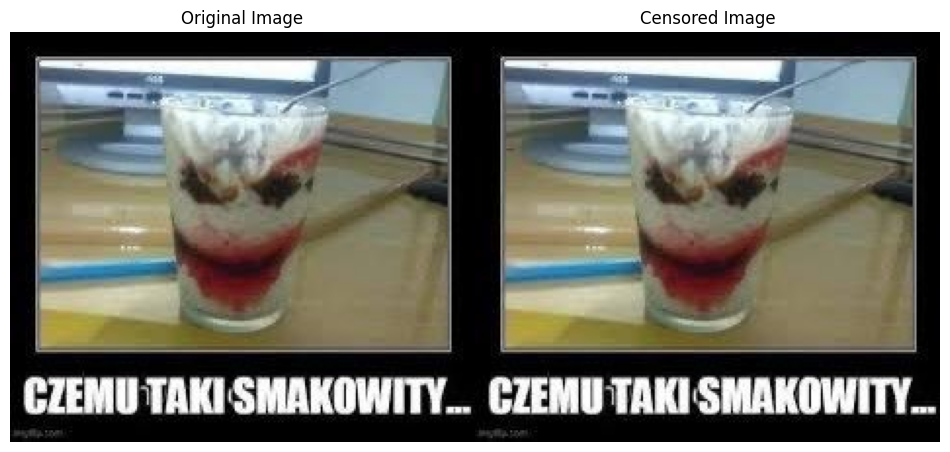

In [188]:
show_images_side_by_side("smakowity.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\obiad_czwartkowy_v1.jpg: 480x640 2 Clothings, 1 Fast food, 2 Foods, 3 Human faces, 2 Mans, 1 Table, 1 Tableware, 43.2ms
Speed: 19.0ms preprocess, 43.2ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\obiad_czwartkowy_v1.jpg: 480x640 2 Clothings, 1 Fast food, 2 Foods, 3 Human faces, 2 Mans, 1 Table, 1 Tableware, 69.0ms
Speed: 5.0ms preprocess, 69.0ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)


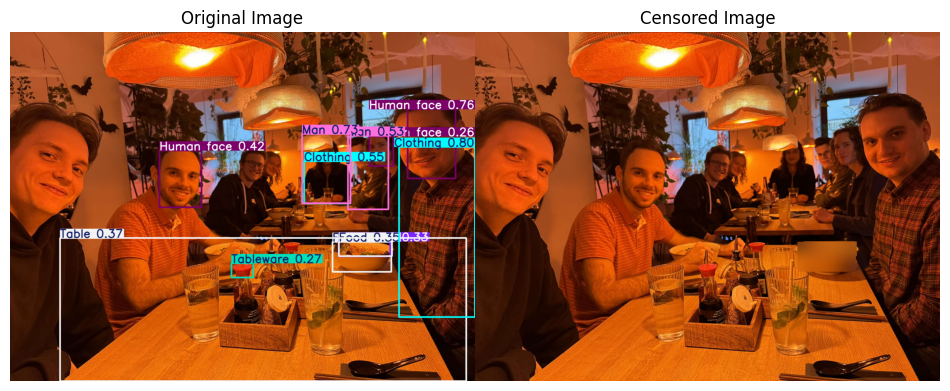

In [189]:
show_images_side_by_side("obiad_czwartkowy_v1.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\obiad_czwartkowy_v2.jpg: 640x480 2 Clothings, 2 Human faces, 1 Man, 1 Table, 1 Woman, 43.2ms
Speed: 5.0ms preprocess, 43.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\obiad_czwartkowy_v2.jpg: 640x480 2 Clothings, 2 Human faces, 1 Man, 1 Table, 1 Woman, 132.6ms
Speed: 5.0ms preprocess, 132.6ms inference, 14.4ms postprocess per image at shape (1, 3, 640, 480)


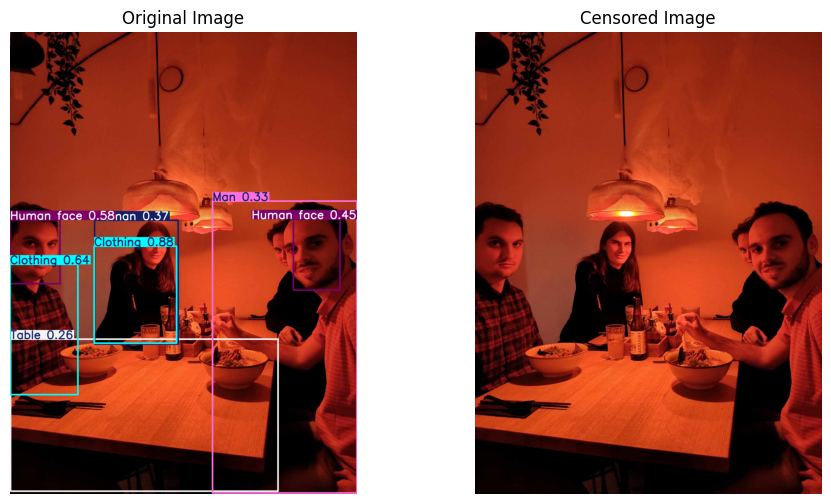

In [190]:
show_images_side_by_side("obiad_czwartkowy_v2.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\pawel.jpg: 640x480 1 Baked goods, 1 Clothing, 2 Foods, 1 Man, 38.9ms
Speed: 5.0ms preprocess, 38.9ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\pawel.jpg: 640x480 1 Baked goods, 1 Clothing, 2 Foods, 1 Man, 187.3ms
Speed: 18.0ms preprocess, 187.3ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 480)


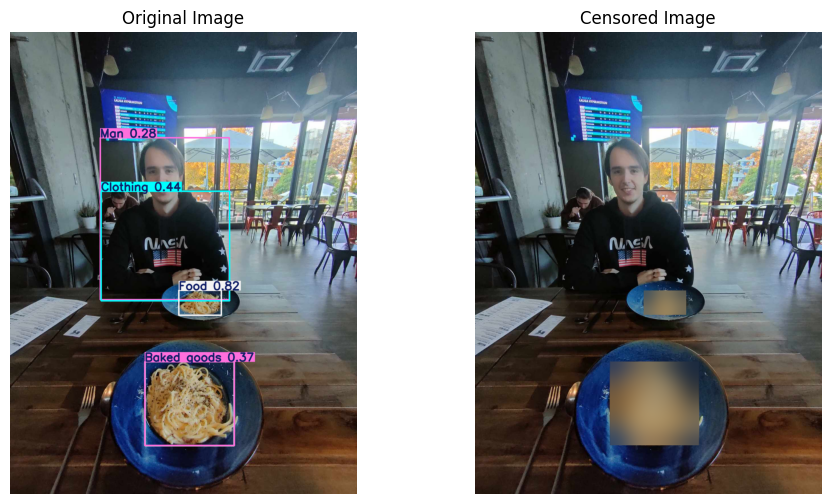

In [191]:
show_images_side_by_side("pawel.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\igor.jpg: 640x480 (no detections), 38.0ms
Speed: 6.0ms preprocess, 38.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\igor.jpg: 640x480 (no detections), 39.2ms
Speed: 5.0ms preprocess, 39.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


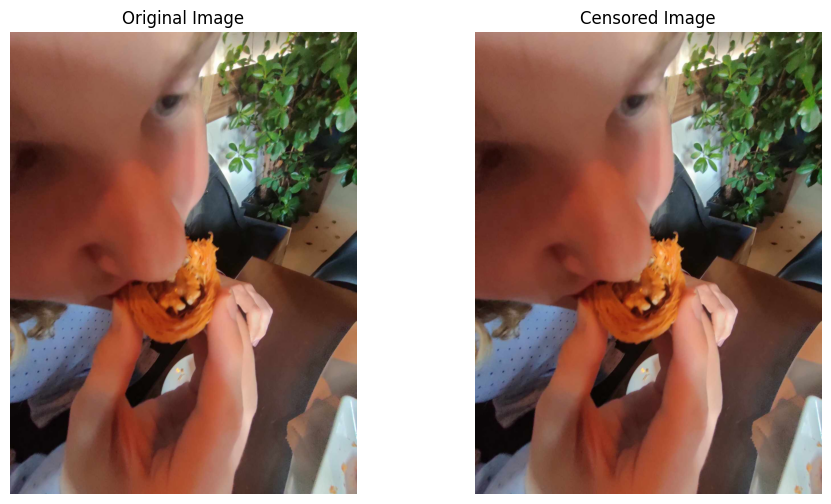

In [192]:
show_images_side_by_side("igor.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\pawel3.jpg: 640x480 1 Bottle, 1 Food, 1 Human face, 39.0ms
Speed: 15.0ms preprocess, 39.0ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\pawel3.jpg: 640x480 1 Bottle, 1 Food, 1 Human face, 57.9ms
Speed: 6.0ms preprocess, 57.9ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 480)


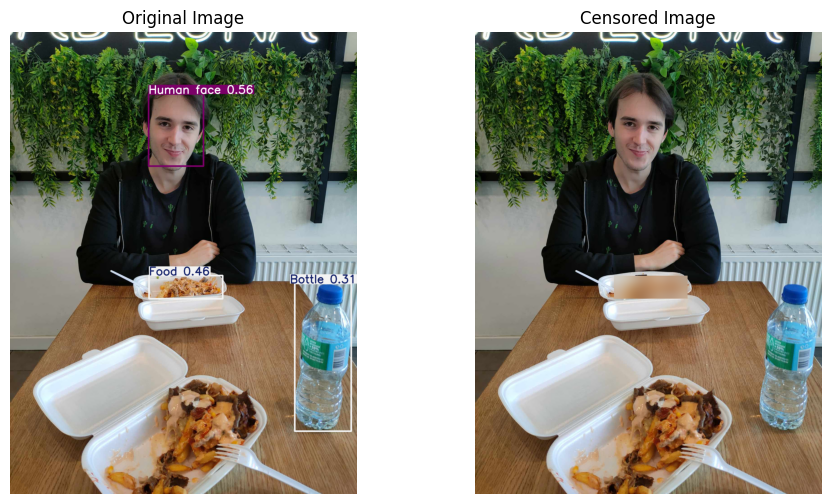

In [193]:
show_images_side_by_side("pawel3.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\tomato.png: 512x640 (no detections), 40.0ms
Speed: 129.2ms preprocess, 40.0ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\tomato.png: 512x640 (no detections), 33.9ms
Speed: 28.4ms preprocess, 33.9ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 640)


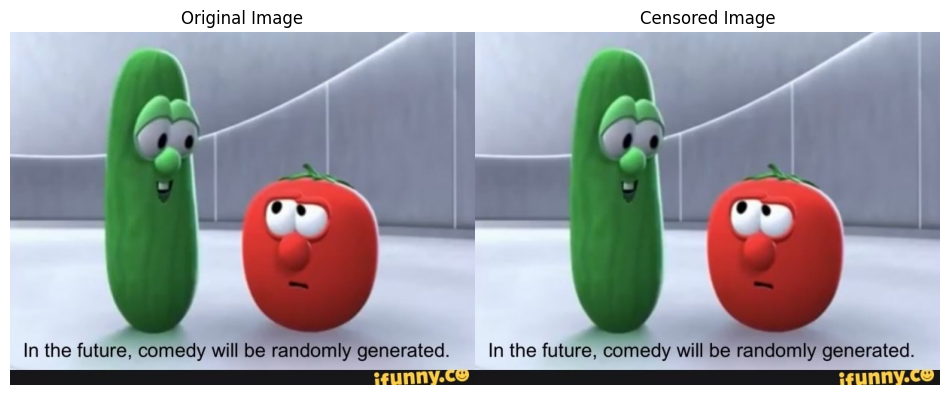

In [194]:
show_images_side_by_side("tomato.png")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\rydze.jpg: 640x480 1 Food, 42.3ms
Speed: 6.0ms preprocess, 42.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\rydze.jpg: 640x480 1 Food, 119.1ms
Speed: 8.0ms preprocess, 119.1ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 480)


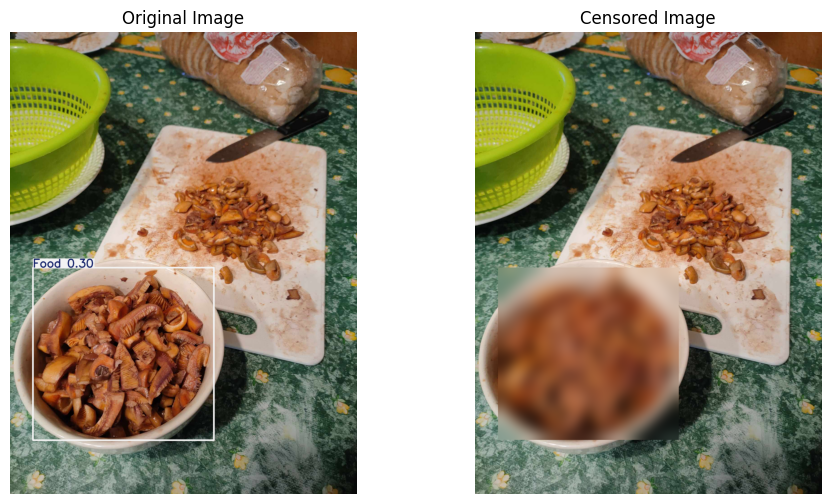

In [195]:
show_images_side_by_side("rydze.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\frit.jpg: 640x384 (no detections), 29.0ms
Speed: 4.2ms preprocess, 29.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\frit.jpg: 640x384 (no detections), 48.5ms
Speed: 5.0ms preprocess, 48.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)


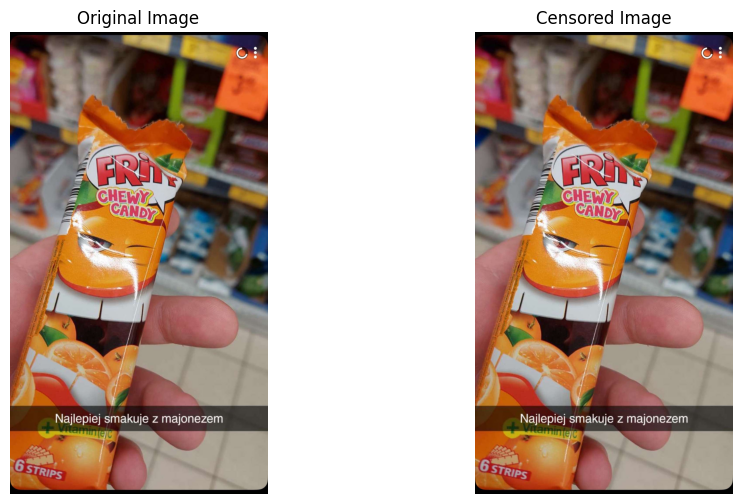

In [197]:
show_images_side_by_side("frit.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\baba.jpg: 448x640 (no detections), 41.1ms
Speed: 5.9ms preprocess, 41.1ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\baba.jpg: 448x640 (no detections), 50.2ms
Speed: 7.0ms preprocess, 50.2ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)


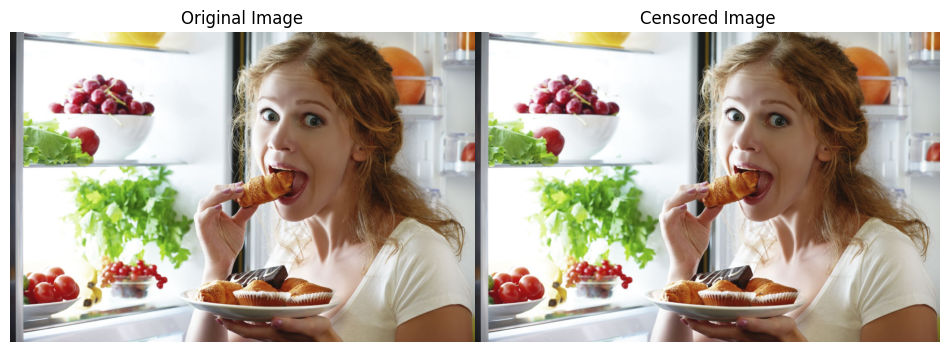

In [198]:
show_images_side_by_side("baba.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\maklowicz.jpg: 640x448 1 Food, 42.7ms
Speed: 5.0ms preprocess, 42.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\maklowicz.jpg: 640x448 1 Food, 66.1ms
Speed: 117.0ms preprocess, 66.1ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 448)


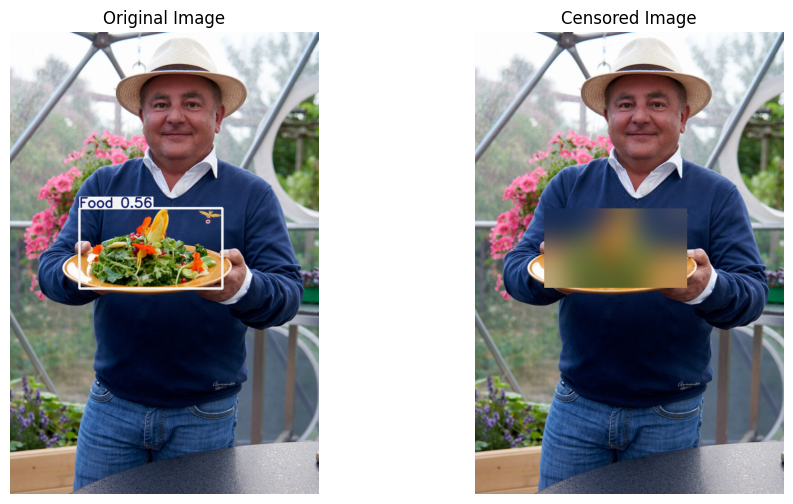

In [199]:
show_images_side_by_side("maklowicz.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\kot.jpg: 448x640 1 Food, 35.3ms
Speed: 33.2ms preprocess, 35.3ms inference, 7.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\kot.jpg: 448x640 1 Food, 38.1ms
Speed: 45.3ms preprocess, 38.1ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)


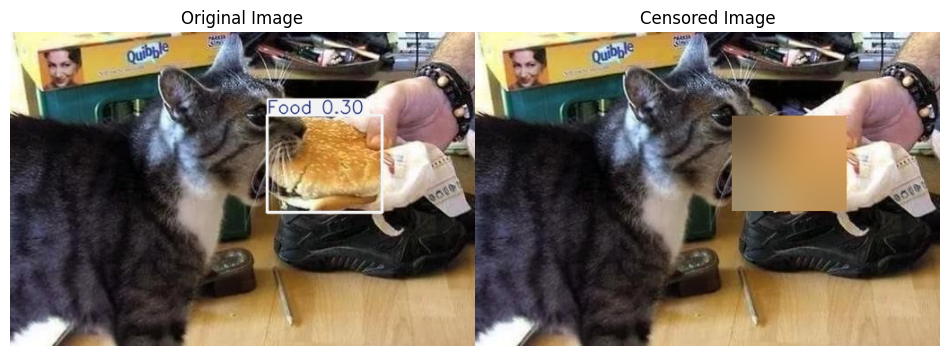

In [200]:
show_images_side_by_side("kot.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\pryt.jpg: 640x480 1 Human face, 67.2ms
Speed: 20.0ms preprocess, 67.2ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\pryt.jpg: 640x480 1 Human face, 39.1ms
Speed: 9.0ms preprocess, 39.1ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 480)


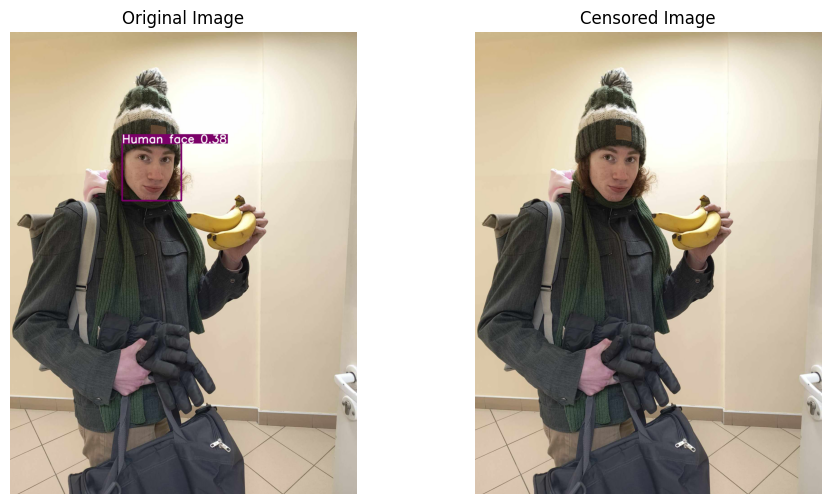

In [201]:
show_images_side_by_side("pryt.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\pryt_i_ja.jpg: 480x640 1 Clothing, 1 Food, 2 Human faces, 1 Snack, 45.0ms
Speed: 9.2ms preprocess, 45.0ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\pryt_i_ja.jpg: 480x640 1 Clothing, 1 Food, 2 Human faces, 1 Snack, 83.6ms
Speed: 10.0ms preprocess, 83.6ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)


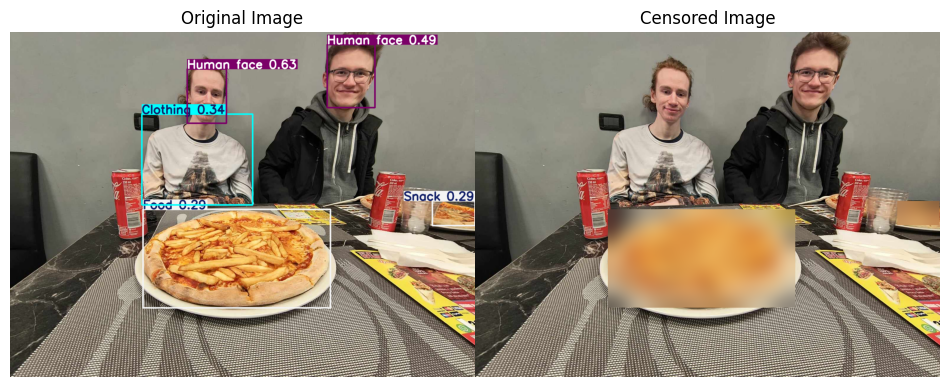

In [206]:
show_images_side_by_side("pryt_i_ja.jpg")


image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\kappa.png: 480x640 1 Bottle, 39.1ms
Speed: 17.5ms preprocess, 39.1ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\k2002\Desktop\kody\moje zadania\.studia\sem7\mro\Image-recognition\lab4\kappa.png: 480x640 1 Bottle, 56.0ms
Speed: 13.0ms preprocess, 56.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


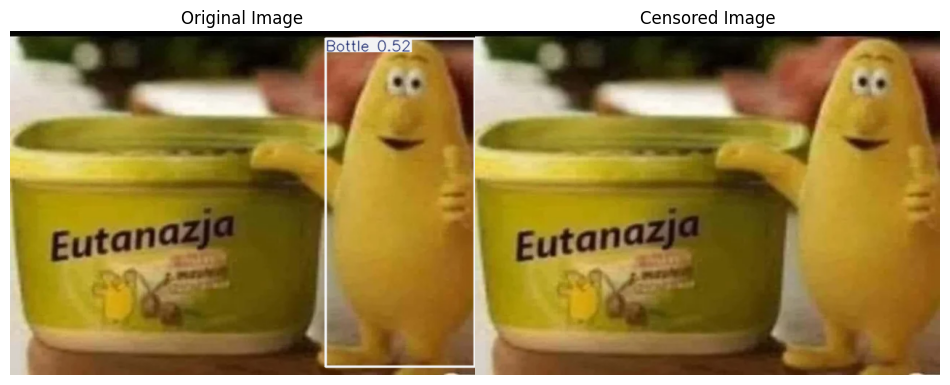

In [208]:
show_images_side_by_side("kappa.png")